In [210]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [211]:
# The data -> x is from -10 to 10, y is from -10 to 10
# labels are sum -> x + y

# nsums = 21*21
# x = np.zeros(nsums)
# y = np.zeros(nsums)
# labels = np.zeros(nsums)

# idx = 0
# for xval in np.arange(-10,11):
#     for yval  in np.arange(-10,11):
#         x[idx] = xval
#         y[idx] = yval
#         labels[idx] = xval + yval
#         idx+=1


In [212]:
x_vals = np.arange(-10, 11)
y_vals = np.arange(-10, 11)

x, y = np.meshgrid(x_vals, y_vals)
labels = x + y

x = x.reshape(-1)
y = y.reshape(-1)
labels = labels.reshape(-1,1)



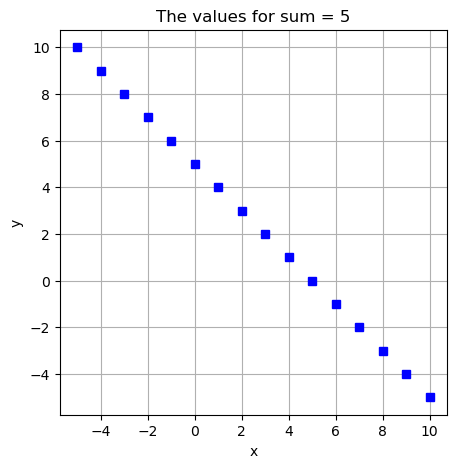

In [213]:
# Format the data into tensors

data = np.stack((x,y), axis=1)

# N= 2500

# data = torch.randint(low=-10,high=11,size=(N,2)).float()

# # "labels"
# labels = torch.sum(data,axis=1,keepdim=True)

dataT = torch.tensor(data).float()
labelsT = torch.tensor(np.reshape(labels, (-1, 1))).float()

# sanity check
# show all the values for x + y = 5
fig = plt.figure(figsize=(5,5))
plt.plot(dataT[np.where(labelsT==5)[0],0],dataT[np.where(labelsT==5)[0],1],'bs')
plt.title('The values for sum = 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [214]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) 

In [215]:
# create a class for the model
def createTheCalculatorNet():

  class calculatorNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,64)      

      ### output layer
      self.output = nn.Linear(64,1)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return  self.output(x)
      
  
  # create the model instance
  net = calculatorNet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [216]:
# test the model with one batch
net,lossfun,optimizer = createTheCalculatorNet()

X,y = next(iter(train_loader))
yHat = net(X)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(68.2930, grad_fn=<MseLossBackward0>)


In [217]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheCalculatorNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  # loop over epochs
  for epochi in range(numepochs):

    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())    

      # accuracy

      yHatInt = torch.round(yHat) #.detach().int()
      yInt =  y.int()
      correctPred = yHatInt == yInt
      batchAcc.append(100*torch.mean(correctPred.float()))

    
    # end of batch loop...

    # accuracy across batches
    trainAcc.append(np.mean(batchAcc))

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
        yHat = net(X)      
   
    yHatInt = torch.round(yHat) #.detach().int()
    yInt =  y.int()
    correctPred = yHatInt == yInt
    testAcc.append(100*torch.mean(correctPred.float()))

  # end epochs

  # function output
  return trainAcc, testAcc, losses, net

In [218]:
for i in range(4):
     trainAcc, testAcc, losses, net = function2trainTheModel()

     print(f"Iteratin {i} Accuracy -> train: {np.mean(trainAcc[:-5]):.2f}  test: {np.mean(testAcc[:-5]):.2f}" )
    



Iteratin 0 Accuracy -> train: 93.11  test: 94.33
Iteratin 1 Accuracy -> train: 94.41  test: 95.56
Iteratin 2 Accuracy -> train: 94.75  test: 95.91
Iteratin 3 Accuracy -> train: 94.07  test: 95.58


Iteratin 3 Accuracy -> train: 94.65  test: 95.23


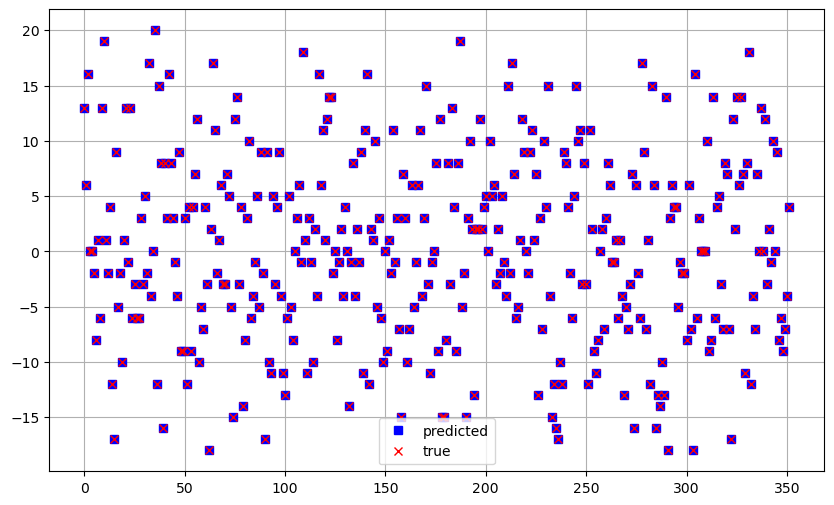

In [219]:
trainAcc, testAcc, losses, net = function2trainTheModel()

yHat = net(train_loader.dataset.tensors[0])

yHatInt = torch.round(yHat).detach()

yInt = train_loader.dataset.tensors[1].int()

what = yHatInt != yInt

print(f"Iteratin {i} Accuracy -> train: {np.mean(trainAcc[:-5]):.2f}  test: {np.mean(testAcc[:-5]):.2f}" )

plt.figure(figsize=(10, 6))
plt.plot(yHatInt, 'bs', label='predicted')
plt.plot(yInt, 'rx', label = 'true')
plt.legend()
plt.grid()
plt.show()